<a href="https://www.kaggle.com/code/dazhengzhu/histopathologic-cancer-detection?scriptVersionId=194213186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/dazhengzhu/histopathologic-cancer-detection?scriptVersionId=193995947" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Histopathologic Cancer Detection

## Introduction


Early and accurate cancer detection is critical for improving patient outcomes. Traditional methods relying on human expertise are time-consuming and prone to errors. The increasing volume of histopathological images further exacerbates this challenge. 

This project aims to develop a deep learning-based model capable of accurately classifying histopathological images as cancerous or non-cancerous. By leveraging the Histopathologic Cancer Detection dataset, we will explore the potential of deep learning techniques to assist doctors in their diagnostic process. Successful implementation of this model could significantly enhance cancer diagnosis efficiency and contribute to advancements in medical image analysis.

### Setup

Import Tensorflow and other necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

print(tf.__version__)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2.16.1


### Data

PatchCamelyon (PCam) packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. 

The data for this project is a slightly modified version of the PCam benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

## Exploratory Data Analysis

In [2]:
import pathlib

train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

train_imgs = list(train_dir.glob('*.tif'))
test_imgs = list(test_dir.glob('*.tif'))

print(len(train_imgs))
print(len(test_imgs))

220025
57458


The dataset uses total 220025 training images, and 57458 images for testing, its too large, we'll select a subset of images for training and validation later.

#### Preview Images

Now take a look at a few pictures to get a better sense of what the dataset look like.

In [3]:
# Get training and testing files
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print('Training image files: ')
print(train_files[:10])
print('Testing image files: ')
print(test_files[:10])

Training image files: 
['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif', '5a32933e093185f5fc91d30fc83ad571c6818d25.tif', '42e77d193e73811e0bb65a0cbd9b01c5c27900fa.tif', '27bb898f54a0b9345f6c4a9083299e4465860861.tif', '89cd55e4300440612347c38f306da688a166fd40.tif', 'cd600f77aa2af7c93dc6cd836e44edada3d8c403.tif']
Testing image files: 
['a7ea26360815d8492433b14cd8318607bcf99d9e.tif', '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif', '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif', 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif', '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif', 'd23c66547f4a00555a174d2fcb860ae399b66edc.tif', 'fabf2fca23f71655974767e29eda86a9b2c97a72.tif', '9730b15862516b8641b9f0ff48db660d95031c32.tif', 'ee85348c0950c2e639776fb555e3452c1f8437c0.tif', 'ef12a0813c504d2d1b2ba485e78d380ad64a0622

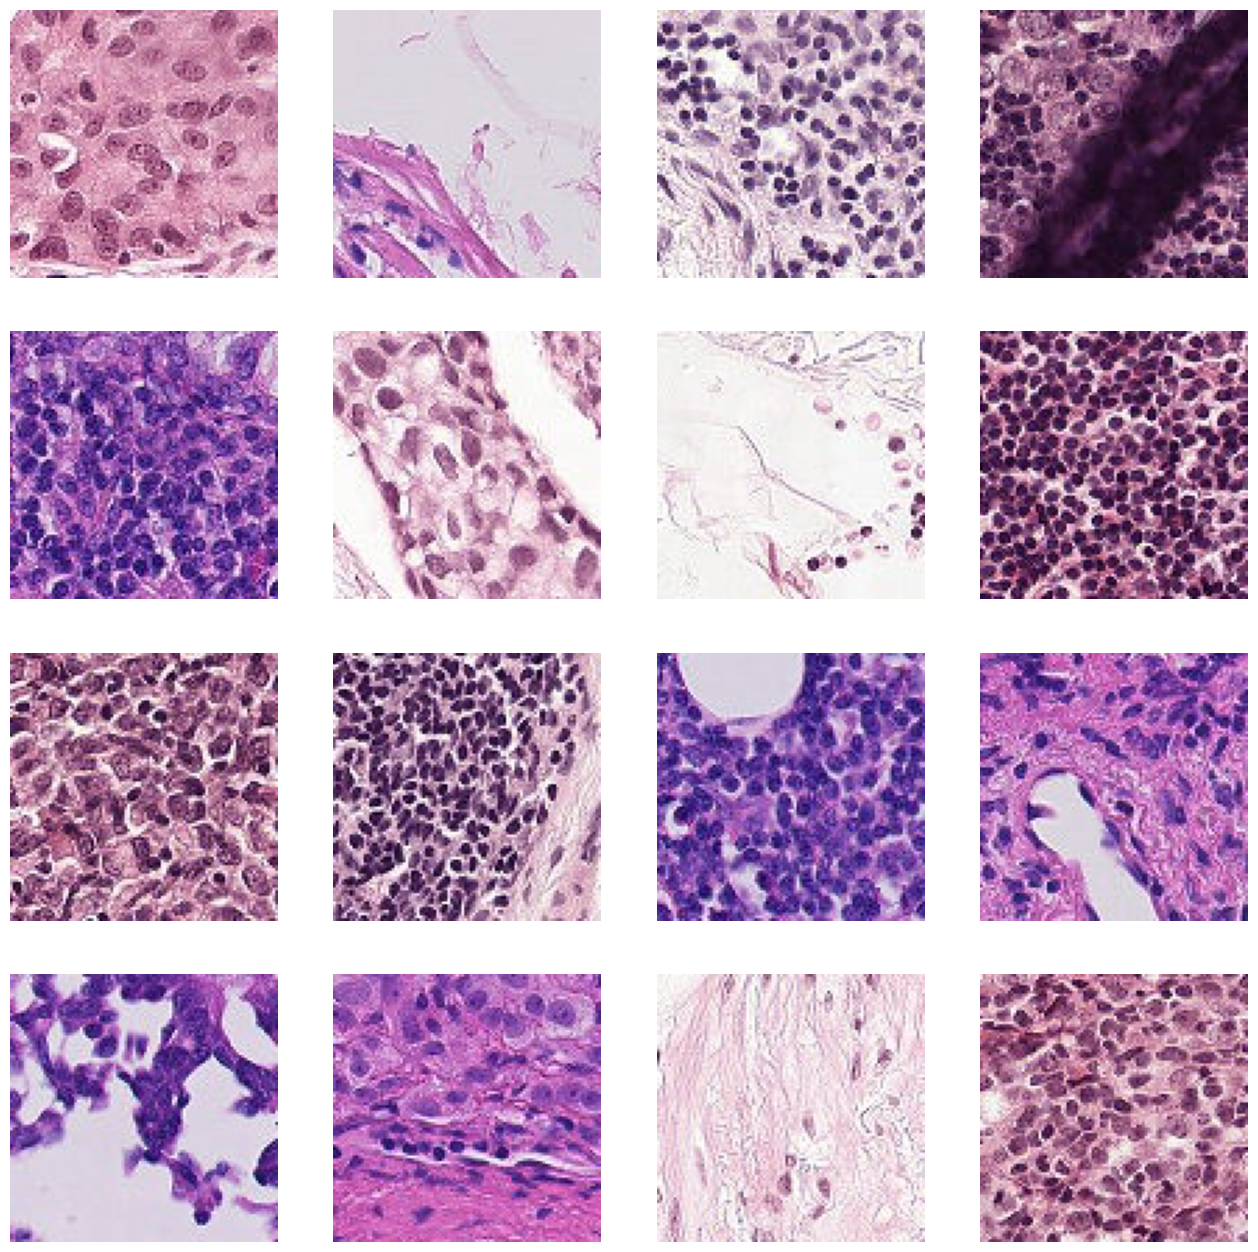

In [4]:
# Create a 4x4 plot
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_train_pix = [os.path.join(train_dir, file)
                for file in train_files[pic_index-8:pic_index]]
next_test_pix = [os.path.join(test_dir, file)
                for file in test_files[pic_index-8:pic_index]]

for i, img_path in enumerate(next_train_pix+next_test_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Data Preprocessing

There are total 220025 images in the train folder, it's a large dataset, we'll select a subset of them for testing and validation.

The image file type is `.tif`, which is not an supported file type with the `keras.utils.image_dataset_from_directory`, fortunately, the `ImageDataGenerator` could help, to use `ImageDataGenerator`, we need to use the label as the name create a new folder named with the label, and then copy the image files to its corresponding label folder.

### Select Train & Validation Samples

To maintain data balance, we'll randomly sample 40000 images from the dataset. Of these, 20000 will have a label of 1, while the remaining 20000 will have a label of 0.

In [5]:
# load labels dataframe
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# Filter samples with the label
pos_df = df[df['label'] == 1]
neg_df = df[df['label'] == 0]

train_pos_df = pos_df.sample(n=20000, random_state=42)
train_neg_df = neg_df.sample(n=20000, random_state=42)
train_df = pd.concat([train_pos_df, train_neg_df])
# Shuffle the dataframe
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Add file type
train_df.id = train_df.id + '.tif'
train_df.label = train_df.label.astype(str)

train_df.head()

,id,label
0,49ad2195c04dc40625cb578cc233fc44deb6cca1.tif,0
1,6f70bbb436e3b6ac1b667beb2e42eab23ef54959.tif,1
2,c302a5e382e40dd3963e0202c5ae60dd096dfe3f.tif,0
3,96f01a14d4724a2b028cc68e46adce3a20f78d05.tif,1
4,bf866de062fe8ab44d89acecf3386cf7974bd863.tif,0


#### Setup Data Generators

Let's setup training and validation data generators. The generators will yield batches of 32 images of size 96x96 and their labels.

We'll use the `keras.preprocessing.image.ImageDataGenerator` class to create generators and using the rescale parameter to normalizing the pixel values to be in the [0,1] range (from original [0, 255] range).

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tifffile as tiff

# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (96, 96)

TRAINING_SUBSET = "training"
VALIDATION_SUBSET = "validation"

# Create ImageDataGenerator with TIFF preprocessing
def tiff_to_rgb(img):
    # Assuming TIFF images have 3 channels (RGB)
    if img.shape[-1] != 3:
        img = tf.image.grayscale_to_rgb(img)
    return img

train_datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=tiff_to_rgb)
val_datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=tiff_to_rgb)

# Create Image Generator in batches of 32
def create_generator(datagen: ImageDataGenerator, subset: str):
    return datagen.flow_from_dataframe(
        directory = train_dir,
        dataframe = train_df,
        x_col = 'id',
        y_col = 'label',
        subset = subset,
        seed = 123,
        shuffle=True,
        target_size = IMG_SIZE,
        batch_size = BATCH_SIZE,
        class_mode = 'binary')

train_generator = create_generator(train_datagen, TRAINING_SUBSET)
val_generator = create_generator(val_datagen, VALIDATION_SUBSET)

Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


## Model

### Build a Baseline Model

The images that will go into our convnet are 96x96 color images.

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Our input feature map is 96x96x3: 96x96 stands for image height x width pixels, 
# and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=IMG_SIZE + (3,))

# Standardize RGB channel values to be in the [0, 1]
x = layers.Rescaling(1./255)(img_input)

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

On top of it are two fully-connected layers. Because we are facing binary classification problem, we will end our network with a sigmoid activation function, so that the output of our network will be a single scalar 0 or 1, indicates the probability the image label is 0 or 1.

In [8]:
# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 128 hidden units
x = layers.Dense(128, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model = Model(img_input, output)

Let's summarize the model:

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,489 (4.59 MB)

 Trainable params: 1,203,489 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

The Output shape column shows how the size of our feature map evolves in each successive layer. We can observe that the convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, let's configure the sepecifications for model training. Since we're facing a binary classification problem, we'll select the `BinaryCrossentropy` loss and use the `RMSprop` optimizer, also monitoring the classification accuracy during the training.

In [10]:
learning_rate=0.001
def compile_model():
    model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
             metrics=['accuracy'])
compile_model()

### Training

Let's train our model for 20 epochs, using 50 batches of training data and 12 batches of validation data per epoch. The `history` object used to capture information during the training.

In [11]:
EPOCHS=10
def fit_model():
    return model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        verbose=2
    )
    
history = fit_model()

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724725654.424140      71 service.cc:145] XLA service 0x7c6630005ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724725654.424194      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724725654.424198      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724725657.674944      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 - 157s - 157ms/step - accuracy: 0.7483 - loss: 0.5186 - val_accuracy: 0.7964 - val_loss: 0.4486
Epoch 2/10
1000/1000 - 50s - 50ms/step - accuracy: 0.8027 - loss: 0.4355 - val_accuracy: 0.8236 - val_loss: 0.3998
Epoch 3/10
1000/1000 - 51s - 51ms/step - accuracy: 0.8240 - loss: 0.3955 - val_accuracy: 0.8142 - val_loss: 0.4150
Epoch 4/10
1000/1000 - 50s - 50ms/step - accuracy: 0.8422 - loss: 0.3584 - val_accuracy: 0.8468 - val_loss: 0.3577
Epoch 5/10
1000/1000 - 51s - 51ms/step - accuracy: 0.8612 - loss: 0.3257 - val_accuracy: 0.8489 - val_loss: 0.3456
Epoch 6/10
1000/1000 - 51s - 51ms/step - accuracy: 0.8778 - loss: 0.2928 - val_accuracy: 0.8221 - val_loss: 0.4000
Epoch 7/10
1000/1000 - 49s - 49ms/step - accuracy: 0.8966 - loss: 0.2551 - val_accuracy: 0.8123 - val_loss: 0.4208
Epoch 8/10
1000/1000 - 50s - 50ms/step - accuracy: 0.9146 - loss: 0.2131 - val_accuracy: 0.8379 - val_loss: 0.3871
Epoch 9/10
1000/1000 - 50s - 50ms/step - accuracy: 0.9314 - loss: 0.1785 - val_accuracy: 

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random training or testing image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


/tmp/ipykernel_24/1234879604.py:39: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/tmp/ipykernel_24/1234879604.py:42: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


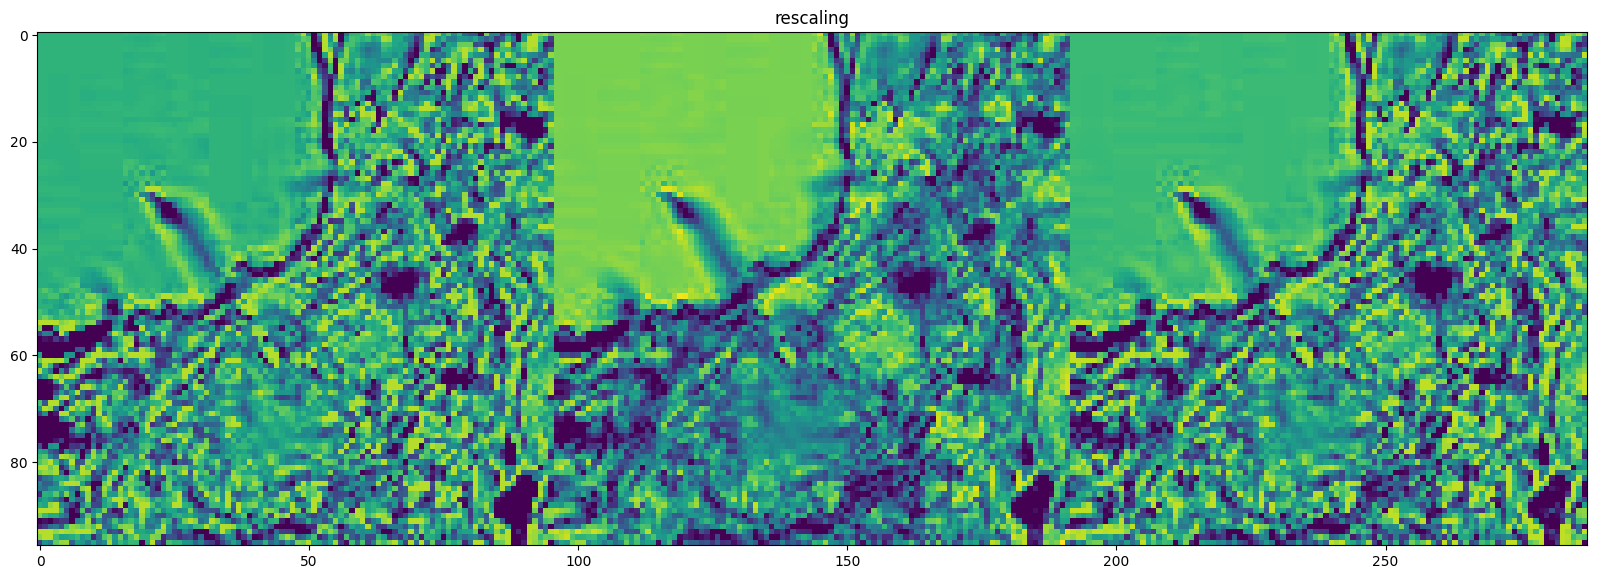

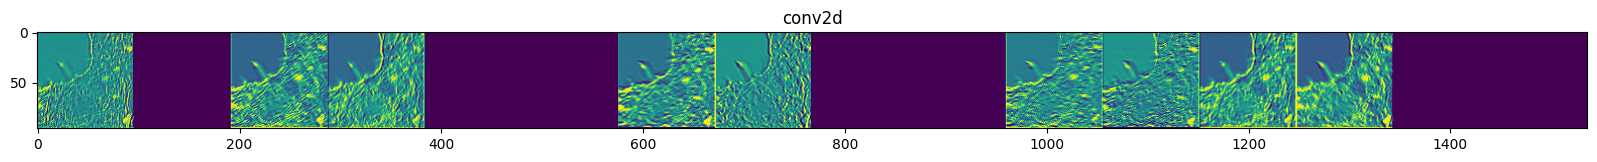

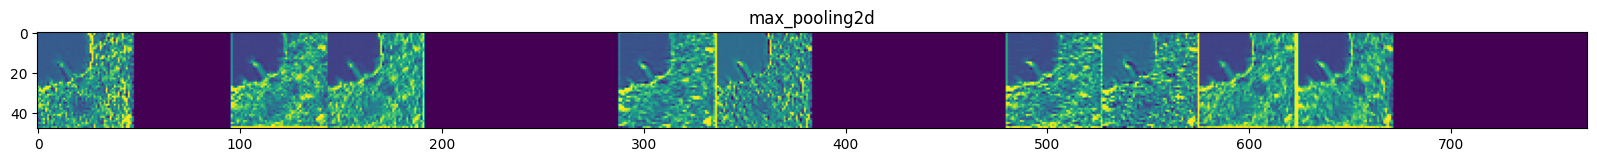

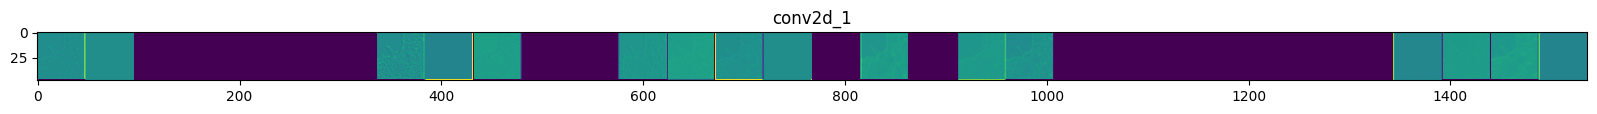

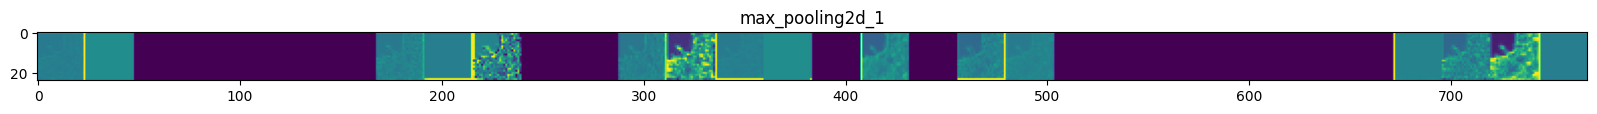

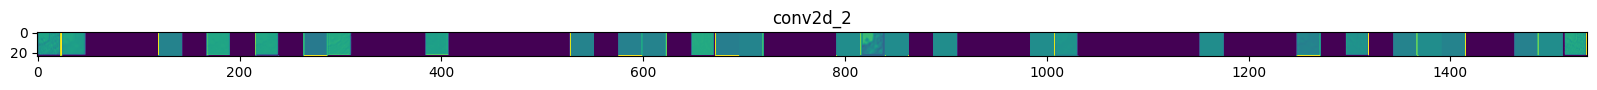

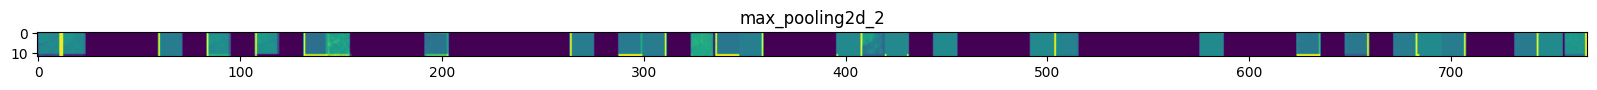

In [12]:
import random
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image from the training set.
img_files = [os.path.join(train_dir, f) for f in train_imgs]
img_path = random.choice(img_files)

img = keras.utils.load_img(img_path, target_size=IMG_SIZE)  # this is a PIL image
x = keras.utils.img_to_array(img)  # Numpy array with shape (96, 96, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 96, 96, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Results And Analysis

### Evaluate Accuracy and Loss for the Baseline Model

Let's plot the training and validation accuracy and loss during training:

In [13]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch

def preview_learning_curve():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

Show the baseline model learning curve:

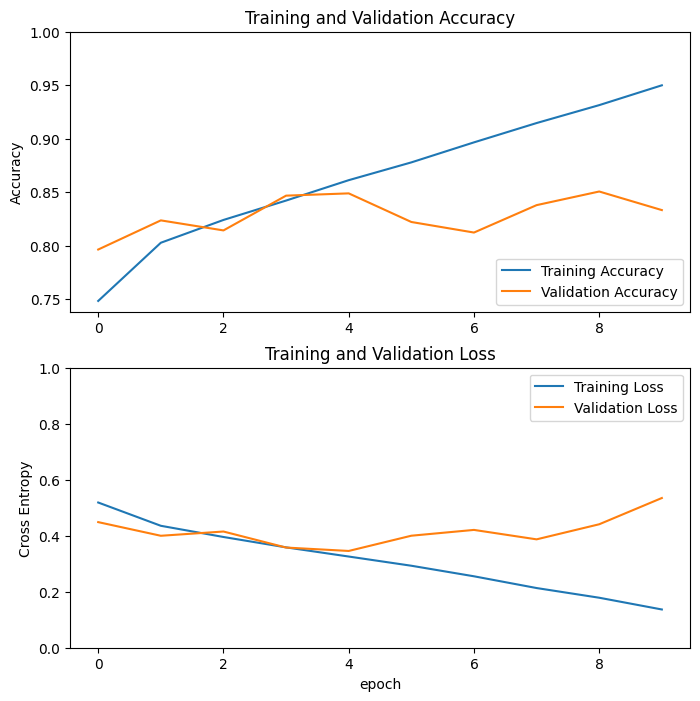

In [14]:
preview_learning_curve()

Below are the observation from the figure:

- Performance: Both training and validation accuracies are generally above 80%, which indicates decent performance, however, there's room for improve validation accuracy.
- Convergence: The accuracies seems to stabilize somewhat towards the end, but there's still significant fluctuation.
- Overfitting: There's a noticeable gap between training and validation accuracy, with training accuracy often higher. This suggests some degree of overfitting.
- Consistency: The validation accuracy shows more variability than the training accuracy, which is common but ideally should be reduced.

### Addressing overfitting in Baseline Model

We could employ several strategies to address overfitting:
    
**Data Augmentation**

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, **our model will never see the exact same picture twice**. 

Let's create a new training data generator and apply several random transformations:

In [15]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.2),
    ]
)

**Dropout**

Another popular strategy is adding **dropout** layer to reduce overfitting:

In [16]:
inputs = layers.Input(shape=IMG_SIZE +(3,))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
# Add dropout layer
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

After employ **data augmentation** and **dropout**, show the model summary:

In [17]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,489 (4.59 MB)

 Trainable params: 1,203,489 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

Let's train our model and preview the results again:

Epoch 1/10


2024-08-27 02:37:48.089477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_6_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1000/1000 - 56s - 56ms/step - accuracy: 0.7103 - loss: 0.5642 - val_accuracy: 0.6848 - val_loss: 0.5959
Epoch 2/10
1000/1000 - 51s - 51ms/step - accuracy: 0.7727 - loss: 0.4866 - val_accuracy: 0.7910 - val_loss: 0.4461
Epoch 3/10
1000/1000 - 51s - 51ms/step - accuracy: 0.7912 - loss: 0.4503 - val_accuracy: 0.7960 - val_loss: 0.4461
Epoch 4/10
1000/1000 - 51s - 51ms/step - accuracy: 0.8059 - loss: 0.4308 - val_accuracy: 0.8031 - val_loss: 0.4435
Epoch 5/10
1000/1000 - 51s - 51ms/step - accuracy: 0.8173 - loss: 0.4082 - val_accuracy: 0.8338 - val_loss: 0.3820
Epoch 6/10
1000/1000 - 53s - 53ms/step - accuracy: 0.8261 - loss: 0.3938 - val_accuracy: 0.8357 - val_loss: 0.3784
Epoch 7/10
1000/1000 - 55s - 55ms/step - accuracy: 0.8298 - loss: 0.3827 - val_accuracy: 0.8227 - val_loss: 0.4018
Epoch 8/10
1000/1000 - 54s - 54ms/step - accuracy: 0.8348 - loss: 0.3768 - val_accuracy: 0.8246 - val_loss: 0.3973
Epoch 9/10
1000/1000 - 57s - 57ms/step - accuracy: 0.8406 - loss: 0.3694 - val_accuracy: 0.

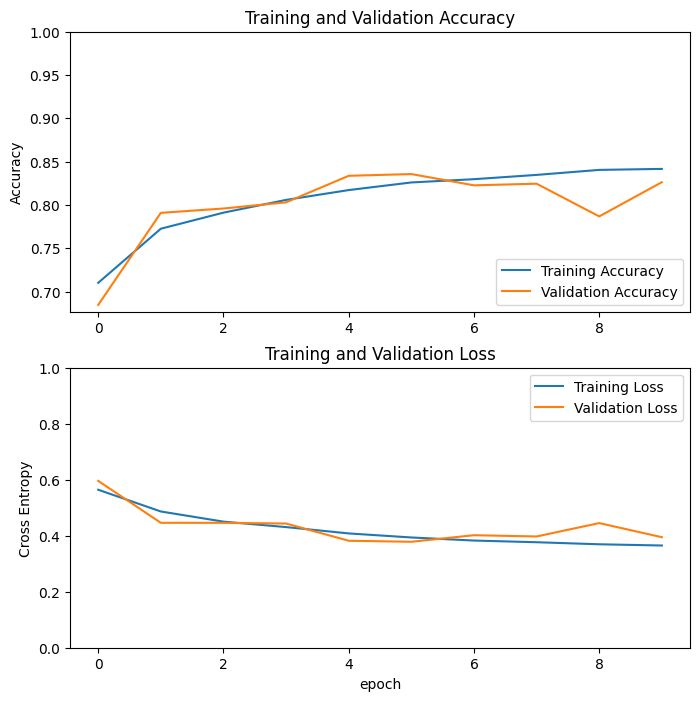

In [18]:
# Compile model -> fit model -> preview learning curve
compile_model()
history = fit_model()
preview_learning_curve()

We can see below improvements:
- Both training and validation accuracies are mostly above 80%.
- Both training and validation accuracies show consistency than before.
- The gap in accuracy between training and validation becomes smaller, this also indicates overfitting reduced.

Ok, this is the baseline model we built empirically, its accuracy looks good but not great, let’s get a taste of what the state-of-the-art (SOTA) Convolutional Neural Network (ConvNet) are like.

### Try EfficientNetV2 Model

EfficientNet is a family of convolutional neural network (CNN) architectures designed to achieve state-of-the-art accuracy while being computationally efficient. Unlike previous methods that arbitrarily scaled network depth, width, or resolution, EfficientNet introduces a compound scaling method that uniformly scales all three dimensions.

EfficientNetV2 is an improved version of the EfficientNet architecture, designed to be even faster to train and more parameter-efficient while maintaining or even surpassing the accuracy of its predecessor.



#### Create EfficientNetB0 model

Let's instantiate a EfficientNetB0 model pre-loaded with weights trained on `ImageNet` first. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [19]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights='imagenet', 
    include_top=False,
    input_shape=IMG_SIZE + (3,))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Build `base_model` and feature extractor layers using the Keras Functional API.

In [20]:
from tensorflow.keras import layers,models
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Create the full model
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

Let's take a look at the efficientnet model architecture:

In [21]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [22]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=val_generator,
                    verbose=2
)

Epoch 1/10


2024-08-27 02:47:17.633330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_8_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1000/1000 - 152s - 152ms/step - accuracy: 0.7990 - loss: 0.4358 - val_accuracy: 0.8140 - val_loss: 0.4078
Epoch 2/10
1000/1000 - 108s - 108ms/step - accuracy: 0.8670 - loss: 0.3092 - val_accuracy: 0.8486 - val_loss: 0.3400
Epoch 3/10
1000/1000 - 110s - 110ms/step - accuracy: 0.8882 - loss: 0.2737 - val_accuracy: 0.8742 - val_loss: 0.2962
Epoch 4/10
1000/1000 - 110s - 110ms/step - accuracy: 0.8989 - loss: 0.2510 - val_accuracy: 0.8750 - val_loss: 0.3001
Epoch 5/10
1000/1000 - 109s - 109ms/step - accuracy: 0.9098 - loss: 0.2300 - val_accuracy: 0.8769 - val_loss: 0.2985
Epoch 6/10
1000/1000 - 109s - 109ms/step - accuracy: 0.9162 - loss: 0.2134 - val_accuracy: 0.8941 - val_loss: 0.2732
Epoch 7/10
1000/1000 - 109s - 109ms/step - accuracy: 0.9226 - loss: 0.1959 - val_accuracy: 0.9003 - val_loss: 0.2545
Epoch 8/10
1000/1000 - 109s - 109ms/step - accuracy: 0.9268 - loss: 0.1883 - val_accuracy: 0.8928 - val_loss: 0.2711
Epoch 9/10
1000/1000 - 109s - 109ms/step - accuracy: 0.9290 - loss: 0.1799 

Let's preview the learning curve:

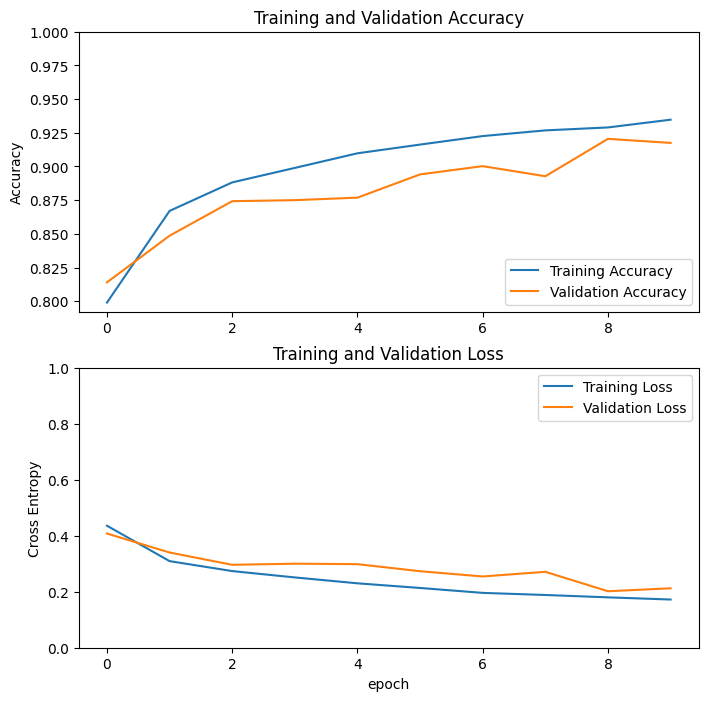

In [23]:
preview_learning_curve()

Much better! The EfficientNetB0 model give significant higher training & validation accuracies and smaller loss values. We will use this model to make prediction.

### Submission

Let's use the `final_model` to make prediction:

In [24]:
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

df_test = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
df_test['filename'] = df_test.id + '.tif'

test_datagen = ImageDataGenerator(preprocessing_function=tiff_to_rgb)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = test_path,
    x_col = 'filename',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = IMG_SIZE,
)

Found 57458 validated image filenames.


In [25]:
predictions = model.predict(test_generator, verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 294s 163ms/step


Convert the predictions to the labels:

In [26]:
label_pred = np.where(predictions > 0.5, 1, 0)
label_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Apply predictions to submission dataframe:

In [27]:
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
submission.label = label_pred
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


Write dataframe to submission csv file:

In [28]:
submission.to_csv('submission.csv', header = True, index = False)

## Conclusion

This project aimed to explore the ConvNet models for Histopathologic Cancer Detection. The EfficientNetB0 model achieved 85% average accuracy on the validation dataset, surpassing the baseline model.

We first build basemodel and achieve decent accuracies for training and validation data set, however, the learning curve shows some degree of overfitting, then we employed reduce overfitting techniques such as enable data augmentation and add dropout layer, these methods show good results on reducing overfitting. 

In order to further improve the accuracy, we select a SOTA EfficientNet model, and apply transfer learning from a pre-trained network, add a new classifier on top of the pretrained model and retrain the model, the result shows significant higher accuracy, while the model demonstrated promising results, further improvements could be achieved by exploring fine-tuning.

Although the model shows good accuracy and consistency, there is still fluctuation in accuracy. There may be some noise in the dataset. We can further adopt anomaly detection methods to clean up the anomalies and reduce the fluctuation in accuracy.

## Reference

- [Keras Functional API](https://www.tensorflow.org/guide/keras/functional)
- [Tensorflow: Classification](https://www.tensorflow.org/tutorials/images/classification)
- [Tensorflow: Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
- [Tensorflow: Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946) (ICML 2019)
- [Meta Pseudo Labels](https://paperswithcode.com/paper/meta-pseudo-labels) (CVPR 2021)